In [1]:
!pip install ucimlrepo

## 1. Dataset
- In-Vehicle Coupon Recommendation
- https://archive.ics.uci.edu/dataset/603/in+vehicle+coupon+recommendation


In [71]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
in_vehicle_coupon_recommendation = fetch_ucirepo(id=603)

# data (as pandas dataframes)
data = in_vehicle_coupon_recommendation.data.original[['passenger', 'weather', 'temperature', 'time', 'coupon', 'expiration', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', "Restaurant20To50", 'toCoupon_GEQ25min', 'direction_same', 'Y']]

## 2. Data Cleaning

### A. Drop Missing Values / Duplicates

In [72]:
data.shape

(12684, 15)

In [73]:
data = data.drop_duplicates()
data = data.dropna(how='any')
data.shape

(11593, 15)

### B. Group time into distinct features
- early morning, morning, midday, afternoon, evening, and night

In [74]:
from datetime import datetime

# Convert string time (e.g 10PM) into a python datetime object (date does not matter) and provide time category:
def categorize_time(str_time):
  _datetime = datetime.strptime(str_time, "%I%p")

  if 0 <= _datetime.hour < 5:
    # Early Morning
    return 1
  elif 5 <= _datetime.hour < 12:
    # Morning
    return 2
  elif 12 <= _datetime.hour < 14:
    # Midday
    return 3
  elif 14 <= _datetime.hour < 18:
    # Afternoon
    return 4
  elif 18 <= _datetime.hour < 21:
    # Evening
    return 5
  else:
    # Night
    return 6

data['time'] = data['time'].apply(categorize_time)

### C. Quantify other categorical features
- weather
- passenger
- coupon type
- expiration
- income ranges
- visits (bar, coffee house, restaurant)


In [75]:
categories = {
    ("weather", ): {
      "Sunny": 1,
      "Rainy": 2,
      "Snowy": 3
  },
    ("passenger", ): {
        "Alone": 1,
        "Friend(s)": 2,
        "Kid(s)": 3,
        "Partner": 4
    },
    ("coupon", ): {
        "Coffee House": 1,
        "Restaurant(<20)": 2,
        "Carry out & Take away": 3,
        "Bar": 4,
        "Restaurant(20-50)": 5,
    },
    ("expiration", ): {
        "2h": 1,
        "1d": 2
    },
    ("income", ): {
        "Less than $12500": 1,
        "$12500 - $24999": 2,
        "$25000 - $37499": 3,
        "$37500 - $49999": 4,
        "$50000 - $62499": 5,
        "$62500 - $74999": 6,
        "$75000 - $87499": 7,
        "$87500 - $99999": 8,
        "$100000 or More": 9
    },
    ("Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"): {
        "never": 1,
        "less1": 2,
        "1~3": 3,
        "4~8": 4,
        "gt8": 5
    }

}

def quantify_column(value):
  return category[value]


for category, _dict in categories.items():
  for c in category:
    data[c] = data[c].map(_dict)

## 3. Model

### A. Split the dataset

In [86]:
X = data.drop('Y', axis = 1)
y = data['Y']
random_seed = 42

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

### B. Initiate the model

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=random_seed),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(random_state=random_seed)
}

### C. Train the models and evaluate their accuracy

In [93]:
model_results = {}
model_predictions = {}
for name, model in models.items():
  # Fit training subset
  model.fit(X_train, y_train)

  # Create y_pred
  y_pred = model.predict(X_test)
  model_predictions[name] = y_pred

  # Evaluate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  model_results[name] = accuracy

In [94]:
model_results

{'Logistic Regression': 0.6205260888313928,
 'Decision Tree': 0.6511427339370418,
 'Random Forest': 0.7084950409659336,
 'Support Vector Machine': 0.5545493747304873}

### D. Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

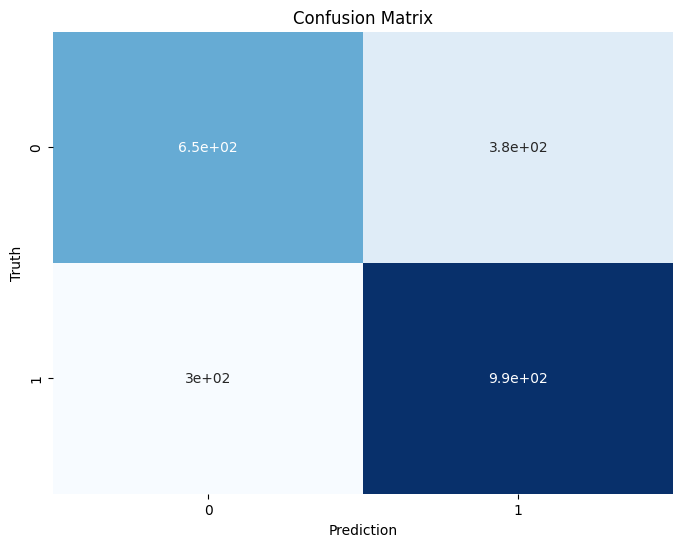

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, model_predictions['Random Forest']), annot=True, cmap='Blues', cbar = False)
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix')

## 4. Model Persistence

In [101]:
import pickle

filename = 'Random Forest.pickle'
pickle.dump(models['Random Forest'], open(filename, 'wb'))
# model_load = pickle.load(open('model.pickle', 'rb'))